### Import Necessary Module and Set Path 

In [72]:
import sqlite3 as lite
import os
import matplotlib.pyplot as plt
import sys
import numpy as np
from matplotlib import cm
import collections

sys.path.insert(0, '../../scripts/')
jupyter_directory = os.getcwd()

## dependencies
* cyclus-input-gen
install by:
```
git clone https://github.com/arfc/cyclus-input-gen
cd cyclus-input-gen
python setup.py install
```

In [73]:
import analysis as an
import random_lifetime_extension as rle
import cyclus_input_gen.from_pris as fp
import cyclus_input_gen.demand_deploy as dd
import cyclus_input_gen.find_replace as fr

In [74]:
# write input file using cyclus_input_gen module
# find database path -> the csv file is in cyclus-input-gen/database
database_path = '/home/teddy/transition-scenarios/input/2017-bae-europe/cyclus-input-gen/database/reactors_pris_2016.csv'
country_list = ['Poland', 'Hungary', 'United Kingdom', 'Czech Republic', 'Slovakia',
                'Bulgaria', 'Finland', 'Netherlands', 'Italy', 'Slovenia',
                'Belgium', 'Spain', 'Lithuania', 'France', 'Sweden', 'Germany', 'Romania']
fp.main(database_path, 19700101, 2280, country_list, 'input_raw.xml')

Then other reactors planned in other countries are added by referencing other sources

In [59]:
# replace fuel cycle facilities
with open('input_raw.xml') as f:
    input_string = f.read()

replace_start = """
<facility>
    <name>mixer</name>
"""
replace_end = """

     <facility>
    <!-- Belgium -->
    <!-- PWR -->
    <name>DOEL-1</name>
    <config>
      <Reactor>
        <fuel_inrecipes>  <val>uox_fuel_recipe</val>       </fuel_inrecipes>
        <fuel_outrecipes> <val>uox_used_fuel_recipe</val>  </fuel_outrecipes>
        <fuel_incommods>  <val>uox</val>                   </fuel_incommods>
        <fuel_outcommods> <val>uox_waste</val>             </fuel_outcommods>
        <fuel_prefs>      <val>1.0</val>                   </fuel_prefs>
        <cycle_time>18</cycle_time>
        <refuel_time>2</refuel_time>
        <assem_size>446.0</assem_size>
        <n_assem_core>83</n_assem_core>
        <n_assem_batch>27</n_assem_batch>
        <power_cap>433</power_cap>
      </Reactor>
    </config>
  </facility>
"""

new_input = fr.replace_file(input_string, replace_start, replace_end, 'facilities.xml')
print(len(new_input))

193453


In [60]:
# delete unnecessary region definition
start = """
<region>
    <name>Sink_Source</name>
    <config><NullRegion/></config>
"""
end = """
  <recipe>
    <name>natl_u_recipe</name>
    <basis>mass</basis>
    <nuclide> <id>U235</id> <comp>0.711</comp> </nuclide>
    <nuclide> <id>U238</id> <comp>99.289</comp> </nuclide>
  </recipe>
"""

new_input = fr.replace_file(new_input, start, end, 'sink_source.xml')
print(len(new_input))

193732


In [61]:
# replace recipe block with contents in recipes.xml
replace_start = """
  <recipe>
    <name>natl_u_recipe</name>
    <basis>mass</basis>
    <nuclide> <id>U235</id> <comp>0.711</comp> </nuclide>
    <nuclide> <id>U238</id> <comp>99.289</comp> </nuclide>
  </recipe>
"""
replace_end = """</simulation>"""

new_input = fr.replace_file(new_input, replace_start, replace_end, 'recipes.xml')
print(len(new_input))


203167


In [62]:
# insert french_facilities insitution definition in France region:
insert_start = """
  <region>
      <name>France</name>
      <config><NullRegion/></config>
"""

insert_end = """
      <institution>
        <name>France_government</name>
"""

new_input = fr.replace_file(new_input, insert_start, insert_end, 'french_facilities_inst.xml', insert=True)
print(len(new_input))

204720


In [63]:
with open('input.xml', 'w') as f:
    f.write(new_input)

### Change lifetimes of Germany, Belgium, and Sweden so the following is met:
1. All German reactors shut down by 2022 (timestep 624)
2. All Swedish reactors shut down in 2050 (timestep 960)
3. All Belgium reactors shut down in 2025 (timestep 660)

You can simply get the institution definitions for these nations in `lifetimes.xml`

### Replace French reactor prototype definitions with the contents in file `france_reactors.xml`
It starts with the reactor definition for CHINON A-2 and ends with definition for FLAMANVILLE-3.
This is done because French reactors have different outcommodity names for separate tracking.

## Run Cyclus Input file (without ASTRIDs)

In [10]:
! rm output.sqlite
! cyclus input.xml -o output.sqlite

              :                                                               
          .CL:CC CC             _Q     _Q  _Q_Q    _Q    _Q              _Q   
        CC;CCCCCCCC:C;         /_\)   /_\)/_/\\)  /_\)  /_\)            /_\)  
        CCCCCCCCCCCCCl       __O|/O___O|/O_OO|/O__O|/O__O|/O____________O|/O__
     CCCCCCf     iCCCLCC     /////////////////////////////////////////////////
     iCCCt  ;;;;;.  CCCC                                                      
    CCCC  ;;;;;;;;;. CClL.                          c                         
   CCCC ,;;       ;;: CCCC  ;                   : CCCCi                       
    CCC ;;         ;;  CC   ;;:                CCC`   `C;                     
  lCCC ;;              CCCC  ;;;:             :CC .;;. C;   ;    :   ;  :;;   
  CCCC ;.              CCCC    ;;;,           CC ;    ; Ci  ;    :   ;  :  ;  
   iCC :;               CC       ;;;,        ;C ;       CC  ;    :   ; .      
  CCCi ;;               CCC        ;;;.      .C ;   

In [11]:
# get sqlite cursor and simulation time data
cur = an.cursor('output.sqlite')
init_year, init_month, duration, timestep = an.simulation_timesteps(cur)

In [13]:
# just france LWR power
power_capacity = an.power_capacity(cur)

power_demand_eq = str(max(power_capacity['France_government']))
print(power_demand_eq)
# with this power capacity, calculate deployment scheme for astrids:
astrid_lifetime = 720
astrid_deployment, powz = dd.get_new_deployment(power_capacity, ['France_government'],
                                                power_demand_eq, 0.6, astrid_lifetime, 840, True)
dd.write_deployinst(astrid_deployment, 'astrid', 'astrid_dep.xml', astrid_lifetime)

64.72999999999999


In [14]:
# add institution wrapper to generated deployinst block
head = """
      <institution>
        <name>France_astrid</name>
        <config>
          <DeployInst>
"""
tail = """

          </DeployInst>
        </config>
      </institution>
"""
with open('astrid_dep.xml') as f:
    read_string = f.read()
    read_string = read_string.replace('<root>', '')
    read_string = read_string.replace('</root>', '')
    tot_string = head + read_string + tail
with open('astrid_dep.xml', 'w') as f:
    f.write(tot_string)

In [15]:
# insert astrid block
with open('input.xml') as f:
    input_string = f.read()

insert_start = """          </DeployInst>
        </config>
      </institution>"""


insert_end = """</region>
  
  <region>
      <name>Finland</name>
      <config><NullRegion/></config>
"""

new_input = fr.replace_file(input_string, insert_start, insert_end, 'astrid_dep.xml', insert=True)
print(len(new_input))
with open('input_astrid.xml', 'w') as f:
    f.write(new_input)

183474
183539
230765


In [52]:
# run the new input with astrid reactors
! rm full_output.sqlite
! cyclus input_astrid.xml -o full_output.sqlite

              :                                                               
          .CL:CC CC             _Q     _Q  _Q_Q    _Q    _Q              _Q   
        CC;CCCCCCCC:C;         /_\)   /_\)/_/\\)  /_\)  /_\)            /_\)  
        CCCCCCCCCCCCCl       __O|/O___O|/O_OO|/O__O|/O__O|/O____________O|/O__
     CCCCCCf     iCCCLCC     /////////////////////////////////////////////////
     iCCCt  ;;;;;.  CCCC                                                      
    CCCC  ;;;;;;;;;. CClL.                          c                         
   CCCC ,;;       ;;: CCCC  ;                   : CCCCi                       
    CCC ;;         ;;  CC   ;;:                CCC`   `C;                     
  lCCC ;;              CCCC  ;;;:             :CC .;;. C;   ;    :   ;  :;;   
  CCCC ;.              CCCC    ;;;,           CC ;    ; Ci  ;    :   ;  :  ;  
   iCC :;               CC       ;;;,        ;C ;       CC  ;    :   ; .      
  CCCi ;;               CCC        ;;;.      .C ;   

In [79]:
# get sqlite cursor and simulation time data
cur = an.cursor('full_output.sqlite')
init_year, init_month, duration, timestep = an.simulation_timesteps(cur)

In [80]:
# get number of reactors and capacity timeseries without astrids
power_cap = an.power_capacity(cur)
power_cap.pop('France_astrid', None)
an.stacked_bar_chart(power_cap, timestep, 'Years',
                    'Net Capacity [MWe]', 'Net Capacity vs Time',
                    'no_astrid', init_year, colormap=cm.tab20c)

french_facilities has no values
Sink_Source_Inst has no values


In [81]:
# get number of reactors and capacity timeseries with astrids
power_cap = an.power_capacity(cur)
power_cap['France_government'] += power_cap['France_astrid']
power_cap.pop('France_astrid', None)
an.stacked_bar_chart(power_cap, timestep, 'Years',
                    'Net Capacity [MWe]', 'Net Capacity vs Time',
                    'full_power', init_year, colormap=cm.tab20c)

french_facilities has no values
Sink_Source_Inst has no values


In [82]:
power_cap = an.power_capacity(cur)
dictionary = {'lwr': power_cap['France_government'],
              'astrid': power_cap['France_astrid']}
init_year, init_month, duration, timestep = an.simulation_timesteps(cur)
an.stacked_bar_chart(dictionary, timestep,
                  'Years', 'Net_Capacity [GWe]',
                  'Net Capacity vs Time',
                  'france_power_plot', init_year)

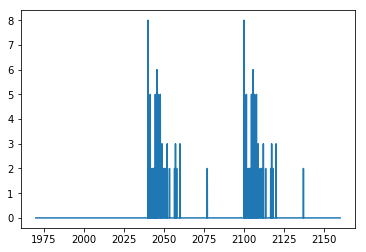

107
Average number of ASTRIDS to deploy per year
1.7833333333333334


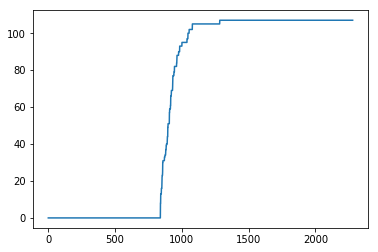

In [83]:
# astrid deployment
entry = cur.execute('SELECT entertime FROM agententry WHERE prototype == "astrid"').fetchall()
num_dict = {}
cum_dict = {}
num_dict['num dep'] = []
for t in timestep:
    astrid_num = 0
    for agent in entry:
        if agent['entertime'] == t:
            astrid_num += 1
    num_dict['num dep'].append(astrid_num)
dep = an.deployments(cur)
cum_dict['cumulative'] = dep['France_astrid']
plt.plot(init_year + timestep/12, num_dict['num dep'])
plt.show()
plt.close()
plt.plot(cum_dict['cumulative'])
print(max(cum_dict['cumulative']))

print('Average number of ASTRIDS to deploy per year')
print(sum(num_dict['num dep']) / (2160-2040) )
an.double_axis_bar_line_plot(num_dict, cum_dict, timestep,
                             'Years', 'Number of SFRs Deployed', ' Number of SFRs Operational',
                             'Build number and cumulative ASTRID Number vs Time', 'sfr_deploy',
                             init_year)

In [84]:
# Pu Composition in Spent Fuels:
pu_frac_spent_uox = cur.execute('SELECT sum(massfrac) FROM recipes LEFT OUTER JOIN compositions ON '
                'compositions.qualid = recipes.qualid '
                'WHERE recipe = "uox_used_fuel_recipe" '
                'and (nucid > 940000000 and nucid < 950000000)').fetchone()
pu_frac_spent_astrid = cur.execute('SELECT sum(massfrac) FROM recipes LEFT OUTER JOIN compositions ON '
                'compositions.qualid = recipes.qualid '
                'WHERE recipe = "sfr_spent_mox_recipe" '
                'and (nucid > 940000000 and nucid < 950000000)').fetchone()
print(pu_frac_spent_uox[0])

0.01188489984729947


In [85]:
# Fuel Used

inst_output_dict = an.commodity_per_institution(cur, 'uox_waste', 960)
total = 0
for key in inst_output_dict:
    print(key)
    try:
        print(inst_output_dict[key]/1000)
        total += inst_output_dict[key]/1000
    except:
        print(key + 'has none you silly \n')

print('Used UOX available for reprocessing Except France')
print(total)


Slovakia_government
2744.684
Czech Republic_government
4143.786
Hungary_government
3118.878
Sweden_government
16014.024
Germany_government
18096.49
Belgium_government
4799.406
french_facilities
french_facilitieshas none you silly 

France_government
France_governmenthas none you silly 

France_astrid
France_astridhas none you silly 

Poland_government
1807.638
Netherlands_government
539.214
Italy_government
577.792
United Kingdom_government
13157.684
Lithuania_government
1051.668
Slovenia_government
765.336
Bulgaria_government
2965.008
Spain_government
9725.296
Romania_government
1742.076
Finland_government
5604.65
Sink_Source_Inst
Sink_Source_Insthas none you silly 

Used UOX available for reprocessing Except France
86853.63


In [86]:
# French UOX UNF total, in sink, and reprocessed
agent_ids = an.agent_ids(cur, 'Reactor')
french = an.facility_commodity_flux(cur, agent_ids, ['french_uox_waste'], True, True)
print('French UNF UOX total in 2050: %f' %french['french_uox_waste'][960])

agent_ids = an.prototype_id(cur, 'LA_HAGUE')
french_rep = an.facility_commodity_flux(cur, agent_ids, ['cooled_french_uox_waste'], False, True)
print('French UNF reprocesed up until 2050: %f' %french_rep['cooled_french_uox_waste'][960])

unused = french['french_uox_waste'][960] - french_rep['cooled_french_uox_waste'][960]
print('French UNF UOX unused in 2050: %f' %unused)

#french['in_sink'] = [x - y for x, y in zip(french['french_uox_waste'], french_rep['cooled_french_uox_waste'])] 
#print('French SNF in Sink')
#print(sum(french['in_sink']))

total_uox_unf = total + unused

print('Total UOX UNF available for Rerprocessing in 2050:%f' %total_uox_unf)

French UNF UOX total in 2050: 64093.768000
French UNF reprocesed up until 2050: 51511.597528
French UNF UOX unused in 2050: 12582.170472
Total UOX UNF available for Rerprocessing in 2050:99435.800472


In [87]:
# plutonium from UNF inventory
pu_iso_list = [238, 239, 240, 241, 242]
mass_frac_list = [0.0001, 0.00518, 0.00232, 0.00126, 0.000487]
for i in range(5):
    print('Pu-%i has mass fraction of %f - %f tonnes available from 2050 UNF' %(pu_iso_list[i], mass_frac_list[i], mass_frac_list[i] * total_uox_unf))
print('Total: %f - %f tonnes available ' %(sum(mass_frac_list), sum(mass_frac_list) * total_uox_unf))


Pu-238 has mass fraction of 0.000100 - 9.943580 tonnes available from 2050 UNF
Pu-239 has mass fraction of 0.005180 - 515.077446 tonnes available from 2050 UNF
Pu-240 has mass fraction of 0.002320 - 230.691057 tonnes available from 2050 UNF
Pu-241 has mass fraction of 0.001260 - 125.289109 tonnes available from 2050 UNF
Pu-242 has mass fraction of 0.000487 - 48.425235 tonnes available from 2050 UNF
Total: 0.009347 - 929.426427 tonnes available 


In [97]:
# UOX loaded up until 2050
agent_ids = an.agent_ids(cur, 'Reactor')
uox_loaded = an.facility_commodity_flux(cur, agent_ids, ['uox'], False, True)
tot_uox_loaded_2050 = uox_loaded['uox'][960]
print('Total UOX Loaded up until 2050: %f MTHM' %tot_uox_loaded_2050)

Total UOX Loaded up until 2050: 154237.246000 MTHM


In [98]:
# LWR MOX loaded up until 2050
mox_loaded = an.facility_commodity_flux(cur, agent_ids, ['mox'], False, True)
tot_mox_loaded_2050 = mox_loaded['mox'][960]
print('Total MOX Loaded up until 2050: %f MTHM' %tot_mox_loaded_2050)

Total MOX Loaded up until 2050: 6463.878000 MTHM


In [99]:
# Tails up until 2050
agent_ids = an.agent_ids(cur, 'Enrichment')
tails = an.facility_commodity_flux(cur, agent_ids, ['tails'], True, True)
tails_2050 = tails['tails'][960]
print('Total tails at 2050: %f' %tails_2050)


Total tails at 2050: 1347339.420595


In [100]:
# Natural U used until 2050
source = an.nat_u_timeseries(cur)
source_2050 = source[960]
print('Total natural U at 2050: %f' %source_2050)

Total natural U at 2050: 1501576.666595


In [101]:
# get tailings timeseries both cumulative and non-cumulative up till 2050

agent_ids = an.agent_ids(cur, 'Storage')
tails_dict = an.facility_commodity_flux(cur, agent_ids, ['tails'], False)
tails_dict['tails'] = tails_dict['tails'][:960]
tails_no_cum = an.facility_commodity_flux(cur, agent_ids, ['tails'], False, False)
tails_no_cum['tails'] = tails_no_cum['tails'][:960]
an.double_axis_bar_line_plot(tails_no_cum, tails_dict, timestep[:960], 'Years', 'Monthly Discharge Mass [MTHM]', 'Cumulative Mass [MTHM]',
                    'Tails Mass vs Time', 'tailings', init_year)

print('Total Tails in MTHM:')
print(max(tails_dict['tails']))

Total Tails in MTHM:
1346560.2140195142


In [102]:
# get total fuel mass vs time plot up until 2050
fuel_dict = an.fuel_usage_timeseries(cur, ['uox', 'mox'], True)
fuel_dict['uox'] = fuel_dict['uox'][:960]
fuel_dict['mox'] = fuel_dict['mox'][:960]
an.stacked_bar_chart(fuel_dict, timestep[:960],
                  'Years', 'Mass[MTHM]',
                  'Total LWR Fuel Mass vs Time',
                  'total_fuel',
                  init_year)

In [ ]:
# where does the astrid fuel come from?
init_year, init_month, duration, timestep = an.simulation_timesteps(cur)

agent_ids = an.agent_ids(cur, 'Reactor')
astrid_loading = an.facility_commodity_flux(cur, agent_ids, ['astrid_fuel_legacy', 'astrid_fuel_new'], False, False)

print('Total ASTRID fuel from spent UOX:')
print(sum(astrid_loading['astrid_fuel_legacy']))
print('Total ASTRID fuel from spent ASTRID fuel:')
print(sum(astrid_loading['astrid_fuel_new']))
print('Total ASTRID Fuel loaded')
print(sum(astrid_loading['astrid_fuel_new']) + sum(astrid_loading['astrid_fuel_legacy']))
print('Total depu used')
print((sum(astrid_loading['astrid_fuel_new']) + sum(astrid_loading['astrid_fuel_legacy'])) * 0.78)

In [105]:
import collections
new_dict = collections.OrderedDict()
new_dict = {'fuel from used uox': astrid_loading['astrid_fuel_legacy'],
            'fuel from used mox': astrid_loading['astrid_fuel_new']}
an.stacked_bar_chart(new_dict, timestep,
                  'Years', 'Mass[MTHM]',
                  'ASTRID Fuel Loading vs Time',
                  'where_fuel',
                  init_year)

print('Total Pu from Spent UOX:')
pu_from_spent_uox = sum(new_dict['fuel from used uox']) * 0.22
uox_rep = pu_from_spent_uox / pu_frac_spent_uox
print(pu_from_spent_uox)
print('Total uox reprocessed', uox_rep)
print('Total Pu from Spent ASTRID Fuel:')
pu_from_spent_astrid = sum(new_dict['fuel from used mox']) * 0.22
astrid_rep = pu_from_spent_astrid / pu_frac_spent_astrid[0]
print(pu_from_spent_astrid)
print('Total astrid fuel reprocessed', astrid_rep)
print('Total Pu Reprocessed:', pu_from_spent_astrid + pu_from_spent_uox)

nonzero = [i for i, e in enumerate(new_dict['fuel from used uox']) if e != 0][-1] - 600
print('average uox reprocessing', uox_rep / nonzero)

nonzero = len([i for i, e in enumerate(new_dict['fuel from used mox']) if e != 0])
print('average astrid fuel reprocessing', astrid_rep / nonzero)

tot = np.array(new_dict['fuel from used uox']) + np.array(new_dict['fuel from used mox'])
nonzero = len(timestep) - 600
print('average total reprocessing', (astrid_rep + uox_rep) / nonzero)

print('Average fuel fab:', sum(tot) / nonzero)


Total Pu from Spent UOX:
630.8544000000053
Total uox reprocessed [53080.3295026]
Total Pu from Spent ASTRID Fuel:
12900.053759999919
Total astrid fuel reprocessed 47026.58753323656
Total Pu Reprocessed: 13530.908159999924
average uox reprocessing [110.81488414]
average astrid fuel reprocessing 35.84343561984494
average total reprocessing [59.58745062]
Average fuel fab: 36.60959999999976


In [106]:
# cum plutonium flux
agent_ids = an.agent_ids(cur, 'separations')
pu = an.facility_commodity_flux(cur, agent_ids, ['uox_Pu', 'astrid_Pu'], True, False)
pu['pu from legacy'] = pu.pop('uox_Pu')
pu['pu from spent sfr fuel'] = pu.pop('astrid_Pu')

an.stacked_bar_chart(pu, timestep, 'Years', 'Mass [MTHM]', 'Total Pu Mass vs Time', 'pu', init_year)


In [107]:
# Total Reprocessed Uranium Stockpile
agent_ids = an.agent_ids(cur, 'sink')
repu_inv = an.facility_commodity_flux(cur, agent_ids, ['uox_U', 'astrid_U'], False, True)
an.stacked_bar_chart(repu_inv, timestep, 'Years', 'Mass[MTHM]', 'Total Rep U Mass vs Time', 'repu', init_year)

print('Total Reprocessed U Inventory:')
print(max([x+y for x, y in zip(repu_inv['uox_U'], repu_inv['astrid_U'])]))

Total Reprocessed U Inventory:
185381.2157748766


In [108]:
# Raffinate
agent_ids = an.agent_ids(cur, 'separations')
reprocess_waste = an.facility_commodity_flux(cur, agent_ids, ['lahague_raffinate', 'uox_raffinate', 'astrid_raffinate'], True, False)
an.stacked_bar_chart(reprocess_waste, timestep, 'Years', 'Mass [MTHM]',
                     'Raffinate Inventory vs Time', 'raffinate', init_year)
print('Total Raffinate:')
print(sum([x+y+z for x, y, z in zip(reprocess_waste['lahague_raffinate'], reprocess_waste['uox_raffinate'], reprocess_waste['astrid_raffinate']
)]))

Total Raffinate:
23539.691789320532


In [109]:
# get spent fuel no_cum and cumulative plot
agent_ids = an.agent_ids(cur, 'Storage')
snf_dict_no_cum = an.facility_commodity_flux(cur, agent_ids, ['uox_waste'],
                                        False, False)
snf_dict = an.facility_commodity_flux(cur, agent_ids, ['uox_waste'],
                                        False, True) 
dictionary = {}
dictionary['monthly_discharge'] = snf_dict_no_cum['uox_waste'][:960]
dict2 = {}
dict2['cum_mass'] = snf_dict['uox_waste'][:960]

an.double_axis_bar_line_plot(dictionary,dict2, timestep[:960], 'Years',  'Monthly Discharge Mass [MTHM]','Cumulative Mass [MTHM]',
                    'Spent Fuel Discharge vs Time', 'snf_discharge', init_year)

agent_ids = an.agent_ids(cur, 'Storage')
snf_dict = an.facility_commodity_flux(cur, agent_ids, ['uox_waste', 'french_uox_waste'],
                                        False)
print('Total UOX Waste in MTHM:')
print(max([x + y for x, y in zip(snf_dict['uox_waste'], snf_dict['french_uox_waste'])]))
print('Total UOX Waste Stored:')
print(max(snf_dict['uox_waste']))
agent_ids = an.agent_ids(cur, 'Sink')
snf_dict = an.facility_commodity_flux(cur, agent_ids, ['mox_waste'],
                                        False)
print('Total MOX Waste in MTHM:')
print(max(snf_dict['mox_waste']))

Total UOX Waste in MTHM:
168557.21600000001
Total UOX Waste Stored:
101481.046
Total MOX Waste in MTHM:
6463.878


In [110]:
# Display important simulation results

# natural uranium demand
dictionary = collections.OrderedDict()
dictionary['natural_uranium'] = an.nat_u_timeseries(cur)
print('Total Natural U in MTHM:')
print(max(dictionary['natural_uranium']))

# get spent fuel timeseries separated by region

agent_ids = an.agent_ids(cur, 'Storage')
comm_dict = an.commodity_flux_region(cur, agent_ids, ['uox_waste', 'french_uox_waste'], False)

# get fuel usage timeseries in stacked bar chart
fuel_dict = an.fuel_usage_timeseries(cur, ['uox', 'mox'])

print('Total UOX usage in MTHM:')
print(max(fuel_dict['uox']))
print('Total MOX usage in MTHM:')
print(max(fuel_dict['mox']))

# get tailings timeseries
agent_ids = an.agent_ids(cur, 'Storage')
tails_dict = an.facility_commodity_flux(cur, agent_ids, ['tails'], False)
print('Total Tailings in MTHM:')
print(max(tails_dict['tails']))

print('Finished!')

Total Natural U in MTHM:
1640988.730645953
Total UOX usage in MTHM:
168557.21600000001
Total MOX usage in MTHM:
6463.878
Total Tailings in MTHM:
1472431.5146459502
Finished!


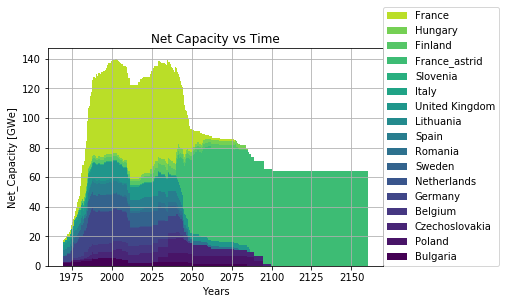

In [111]:
# Display Net Capacity vs Time
from IPython.display import Image
Image(filename='power_plot.png')

In [112]:
# Display Number of Reactors vs Time
from IPython.display import Image
Image(filename='num_plot.png')

FileNotFoundError: [Errno 2] No such file or directory: 'num_plot.png'

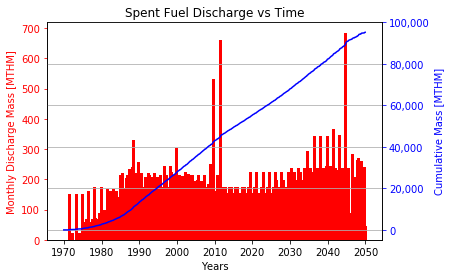

In [198]:
# Display natural U demand  vs Time
from IPython.display import Image
Image(filename='cum_mass_snf_discharge.png')

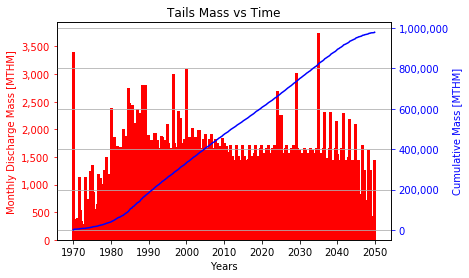

In [199]:
# Display spent fuel vs Time
from IPython.display import Image
Image(filename='tails_tailings.png')

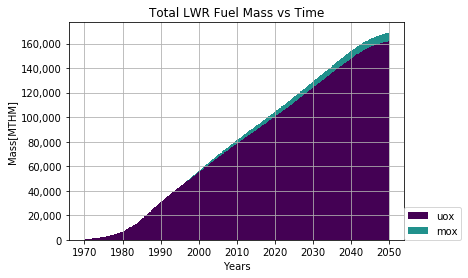

In [200]:
# Display total fuel usage  vs Time
from IPython.display import Image
Image(filename='total_fuel.png')